In [1]:
import torch
import scanpy as sc

from sklearn.metrics import adjusted_rand_score, silhouette_score, adjusted_mutual_info_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import os
from sklearn.decomposition import PCA
from scvi.model import SCVI
from scripts import constants
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

Global seed set to 0


In [2]:
dataset = "grubman_2019"
adata = sc.read_h5ad(
    os.path.join(
        constants.DEFAULT_DATA_PATH,
        f"{dataset}/preprocessed/adata_top_2000_genes.h5ad",
    )
)

target_adata = adata[adata.obs["batchCond"] != "ct"].copy()
background_adata = adata[adata.obs["batchCond"] == "ct"].copy()

target_trans_adata = target_adata.copy()
background_trans_adata = background_adata.copy()

SCVI.setup_anndata(target_adata, layer="count")
SCVI.setup_anndata(target_trans_adata)

torch_device = "cuda:6"
seed = 123

contrastiveVI_model = torch.load(
    os.path.join(constants.DEFAULT_RESULTS_PATH, f"{dataset}/contrastiveVI/latent_10/{seed}/model.ckpt"),
    map_location=torch_device,
)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["count"]                                               
INFO     Successfully registered anndata object containing 5764 cells, 2000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 5

During startup - Warning messages:
1: package ‘methods’ was built under R version 3.6.1 
2: package ‘datasets’ was built under R version 3.6.1 
3: package ‘utils’ was built under R version 3.6.1 
4: package ‘grDevices’ was built under R version 3.6.1 
5: package ‘graphics’ was built under R version 3.6.1 
6: package ‘stats’ was built under R version 3.6.1 


In [3]:
from anndata import AnnData

salient_latent_representations = contrastiveVI_model.get_latent_representation(
    adata=target_adata,
    representation_kind="salient"
)
adata_salient = AnnData(X = salient_latent_representations, obs=target_adata.obs)

background_latent_representations = contrastiveVI_model.get_latent_representation(
    adata=target_adata,
    representation_kind="background"
)
adata_background = AnnData(X = background_latent_representations, obs=target_adata.obs)

In [4]:
sc.pp.neighbors(adata_salient)
sc.tl.leiden(adata_salient, resolution=0.25)

In [5]:
from umap import UMAP

umap_background = UMAP(random_state=42).fit_transform(adata_background.X)
umap_salient = UMAP(random_state=42).fit_transform(adata_salient.X)

In [6]:
def format_axis(ax):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")

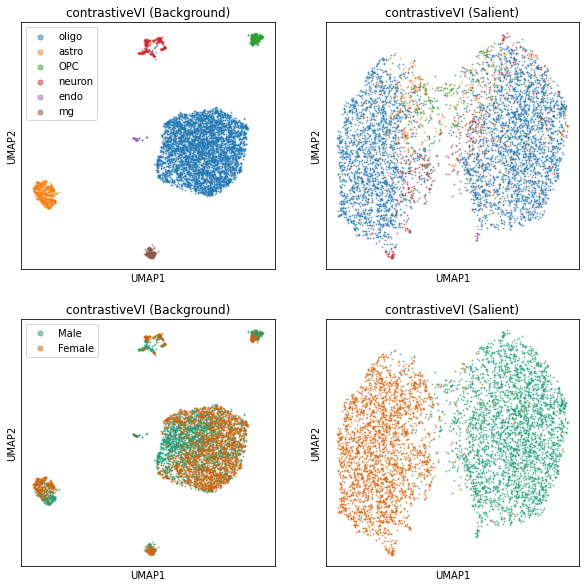

In [62]:
import matplotlib.cm as cm

s = 1
alpha = 0.5

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

cell_type_labels = target_adata.obs["cellType"]
for i, label in enumerate(cell_type_labels.unique()):
    ax1.scatter(
        umap_background[:, 0][cell_type_labels == label],
        umap_background[:, 1][cell_type_labels == label],
        s=s,
        label=label,
        alpha=alpha,
        color=cm.tab10(i)
    )
    
format_axis(ax1)
ax1.set_title("contrastiveVI (Background)")

for i, label in enumerate(cell_type_labels.unique()):
    ax2.scatter(
        umap_salient[:, 0][cell_type_labels == label],
        umap_salient[:, 1][cell_type_labels == label],
        s=s,
        label=label,
        alpha=alpha,
        color=cm.tab10(i)
    )
format_axis(ax2)
ax2.set_title("contrastiveVI (Salient)")
ax1.legend(markerscale=5, loc='upper left')


cell_type_labels = target_adata.obs["sex"]
for i, label in enumerate(cell_type_labels.unique()):
    ax3.scatter(
        umap_background[:, 0][cell_type_labels == label],
        umap_background[:, 1][cell_type_labels == label],
        s=s,
        label=label,
        alpha=alpha,
        color=cm.Dark2(i)
    )
    
format_axis(ax3)
ax3.set_title("contrastiveVI (Background)")

for i, label in enumerate(cell_type_labels.unique()):
    ax4.scatter(
        umap_salient[:, 0][cell_type_labels == label],
        umap_salient[:, 1][cell_type_labels == label],
        s=s,
        label=label,
        alpha=alpha,
        color=cm.Dark2(i)
    )
    
format_axis(ax4)
ax4.set_title("contrastiveVI (Salient)")
ax3.legend(markerscale=5, loc='upper left')

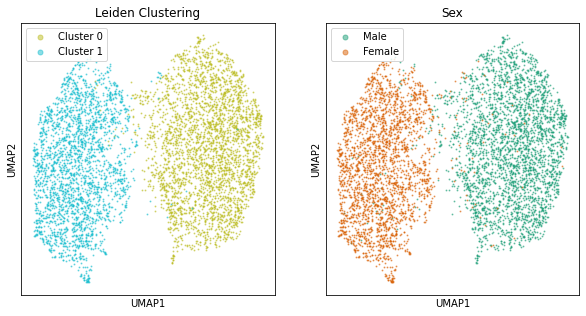

In [8]:
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(10, 5))

cell_type_labels = adata_salient.obs["leiden"]
colors = ['tab:olive', 'tab:cyan']
for i, label in enumerate(cell_type_labels.unique()):
    ax3.scatter(
        umap_salient[:, 0][cell_type_labels == label],
        umap_salient[:, 1][cell_type_labels == label],
        s=s,
        label="Cluster {}".format(label),
        alpha=alpha,
        color=colors[i]
    )
    
format_axis(ax3)
ax3.legend(markerscale=5, loc='upper left')
ax3.set_title("Leiden Clustering")

cell_type_labels = target_adata.obs["sex"]
for i, label in enumerate(cell_type_labels.unique()):
    ax4.scatter(
        umap_salient[:, 0][cell_type_labels == label],
        umap_salient[:, 1][cell_type_labels == label],
        s=s,
        label=label,
        alpha=alpha,
        color=cm.Dark2(i)
    )
    
format_axis(ax4)
ax4.set_title("Sex")
ax4.legend(markerscale=5, loc='upper left')

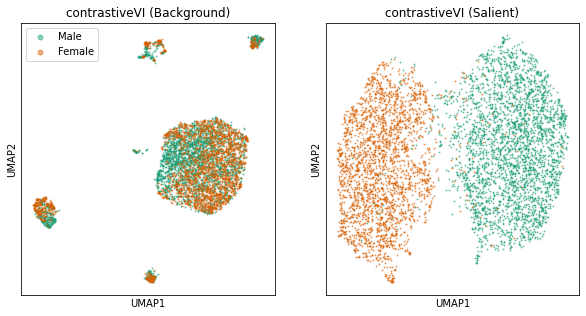

In [9]:
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(10, 5))

cell_type_labels = target_adata.obs["sex"]
for i, label in enumerate(cell_type_labels.unique()):
    ax3.scatter(
        umap_background[:, 0][cell_type_labels == label],
        umap_background[:, 1][cell_type_labels == label],
        s=s,
        label=label,
        alpha=alpha,
        color=cm.Dark2(i)
    )
    
format_axis(ax3)
ax3.set_title("contrastiveVI (Background)")

for i, label in enumerate(cell_type_labels.unique()):
    ax4.scatter(
        umap_salient[:, 0][cell_type_labels == label],
        umap_salient[:, 1][cell_type_labels == label],
        s=s,
        label=label,
        alpha=alpha,
        color=cm.Dark2(i)
    )
    
format_axis(ax4)
ax4.set_title("contrastiveVI (Salient)")
ax3.legend(markerscale=5, loc='upper left')

In [ ]:
mitochondrial_genes = [
    "MT-ND1",
    "MT-ND2",
    "MT-ND3",
    "MT-ND4",
    "MT-CO2",
    "MT-CO3",
    "MT-ATP6"
]

sc.tl.score_genes(
    target_adata,
    mitochondrial_genes,
    use_raw=False,
    score_name='MT_score',
    random_state=42
)

heat_shock_genes = [
    "HSPA1A", 
    "HSP90A1"
]

sc.tl.score_genes(
    target_adata,
    heat_shock_genes,
    use_raw=False,
    score_name='HS_score',
    random_state=42
)

cytokine_genes = [
    "HLA-E",
    "MEF2C",
    "NFKBIA"
]

sc.tl.score_genes(
    target_adata,
    cytokine_genes,
    use_raw=False,
    score_name='cyto_score',
    random_state=42
)

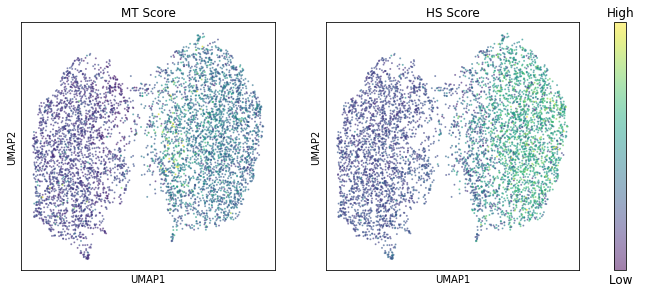

In [72]:
import matplotlib.cm as cm

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 4.56))
s=1
alpha=0.5

ax1.scatter(
    umap_salient[:, 0],
    umap_salient[:, 1],
    s=s,
    label=label,
    alpha=alpha,
    c=target_adata.obs['MT_score']
)    
format_axis(ax1)
ax1.set_title("MT Score")

s = ax2.scatter(
    umap_salient[:, 0],
    umap_salient[:, 1],
    s=s,
    label=label,
    alpha=alpha,
    c=target_adata.obs['HS_score']
)
format_axis(ax2)
ax2.set_title("HS Score")
cbar = fig.colorbar(s, ax=(ax1, ax2))

min_val, max_val = min(target_adata.obs['HS_score']), max(target_adata.obs['HS_score'])
cbar.ax.set_title('High', fontsize=12)
cbar.set_ticks([])
cbar.set_label("Low     ", y=-0.01, rotation=0, fontsize=12)

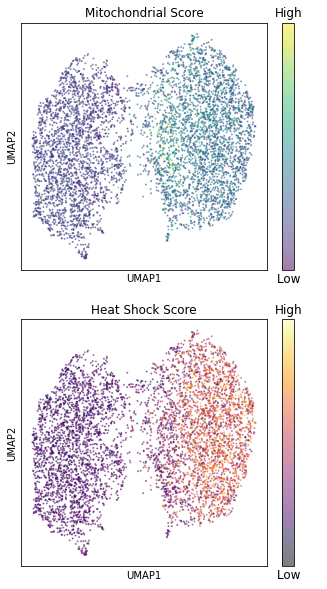

In [84]:
import matplotlib.cm as cm

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5.5, 10))
s=1
alpha=0.5

s = ax1.scatter(
    umap_salient[:, 0],
    umap_salient[:, 1],
    s=s,
    label=label,
    alpha=alpha,
    c=target_adata.obs['MT_score']
)    
format_axis(ax1)
ax1.set_title("Mitochondrial Score")
cbar = fig.colorbar(s, ax=ax1)
min_val, max_val = min(target_adata.obs['MT_score']), max(target_adata.obs['MT_score'])
cbar.ax.set_title('High', fontsize=12)
cbar.set_ticks([])
cbar.set_label("Low     ", y=-0.01, rotation=0, fontsize=12)

s = 1
s = ax2.scatter(
    umap_salient[:, 0],
    umap_salient[:, 1],
    s=s,
    label=label,
    alpha=alpha,
    c=target_adata.obs['HS_score'],
    cmap='inferno'
)
format_axis(ax2)
ax2.set_title("Heat Shock Score")
cbar = fig.colorbar(s, ax=ax2)

min_val, max_val = min(target_adata.obs['HS_score']), max(target_adata.obs['HS_score'])
cbar.ax.set_title('High', fontsize=12)
cbar.set_ticks([])
cbar.set_label("Low     ", y=-0.01, rotation=0, fontsize=12)

In [ ]:
import matplotlib.cm as cm

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 5))
s=1
alpha=0.5

ax1.scatter(
    umap_salient[:, 0],
    umap_salient[:, 1],
    s=s,
    label=label,
    alpha=alpha,
    c=target_adata[:, "LINGO1"].X.reshape(-1)
)    
format_axis(ax1)
ax1.set_title("LINGO1")

s = ax2.scatter(
    umap_salient[:, 0],
    umap_salient[:, 1],
    s=s,
    label=label,
    alpha=alpha,
    c=target_adata[:, "NEAT1"].X.reshape(-1)
)
format_axis(ax2)
ax2.set_title("NEAT1")
fig.colorbar(s, ax=(ax1, ax2))

### Examine specific cell types

In [ ]:
cell = 'mg'

adata_salient_mg = adata_salient[adata_salient.obs['cellType'] == cell]
umap_salient_mg = UMAP(random_state=42).fit_transform(adata_salient_mg.X)
sc.pp.neighbors(adata_salient_mg)
sc.tl.leiden(adata_salient_mg, resolution=0.5)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
s=1
alpha=0.5
gene = 'FRMD4A' # Keeping this in the back pocket for later

format_axis(ax1)
ax1.scatter(
    umap_salient_mg[:, 0],
    umap_salient_mg[:, 1],
    c=target_adata[target_adata.obs['cellType'] == cell][:, gene].X.reshape(-1)
)
ax1.set_title("Microglia {}".format(gene))

format_axis(ax2)

gene = 'SDK1'
ax2.scatter(
    umap_salient_mg[:, 0],
    umap_salient_mg[:, 1],
    c=target_adata[target_adata.obs['cellType'] == cell][:, gene].X.reshape(-1)
)
ax2.set_title("Microglia {}".format(gene))

In [ ]:
cell = 'astro'

adata_salient_astro = adata_salient[adata_salient.obs['cellType'] == cell]
umap_salient_astro = UMAP(random_state=42).fit_transform(adata_salient_astro.X)
sc.pp.neighbors(adata_salient_astro)
sc.tl.leiden(adata_salient_astro, resolution=0.25)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
s=1
alpha=0.5

format_axis(ax1)
ax1.scatter(
    umap_salient_astro[:, 0],
    umap_salient_astro[:, 1],
    c=[int(x) for x in adata_salient_astro.obs['leiden'].values.reshape(-1)]
)
ax1.set_title("Astrocytes Leiden")
ax1.legend()

labels = target_adata[target_adata.obs['cellType'] == 'astro'].obs["sex"]
for i, label in enumerate(labels.unique()):
    ax2.scatter(
        umap_salient_astro[:, 0][labels == label],
        umap_salient_astro[:, 1][labels == label],
        label=label,
        color=cm.Dark2(i)
    )
ax2.set_title("Astrocytes Sex")
format_axis(ax2)
ax2.legend()

In [ ]:
adata_tmp = target_adata[target_adata.obs['cellType'] == 'astro'].copy()
adata_tmp.obs['leiden'] = adata_salient_astro.obs['leiden']

In [ ]:
delta = 0.5

In [ ]:
de_result_astro = contrastiveVI_model.differential_expression(
    adata=adata_tmp,
    groupby="sex",
    group1="Male",
    group2="Female",
    idx1=None,
    idx2=None,
    mode="change",
    delta=delta,
    batch_size=128,
    all_stats=True,
    batch_correction=False,
    batchid1=None,
    batchid2=None,
    fdr_target=0.05,
    silent=False,
)

In [ ]:
adata_tmp = target_adata[target_adata.obs['cellType'] == 'mg'].copy()
adata_tmp.obs['leiden'] = adata_salient_astro.obs['leiden']

de_result_mg = contrastiveVI_model.differential_expression(
    adata=adata_tmp,
    groupby="sex",
    group1="Male",
    group2="Female",
    idx1=None,
    idx2=None,
    mode="change",
    delta=delta,
    batch_size=128,
    all_stats=True,
    batch_correction=False,
    batchid1=None,
    batchid2=None,
    fdr_target=0.05,
    silent=False,
)

In [ ]:
adata_tmp = target_adata.copy()
adata_tmp.obs['leiden'] = adata_salient.obs['leiden']

In [ ]:
de_result_total = contrastiveVI_model.differential_expression(
    adata=adata_tmp,
    groupby="sex",
    group1="Male",
    group2="Female",
    idx1=None,
    idx2=None,
    mode="change",
    delta=delta,
    batch_size=128,
    all_stats=True,
    batch_correction=False,
    batchid1=None,
    batchid2=None,
    fdr_target=0.05,
    silent=False,
)

In [ ]:
top_genes_astro = de_result_astro[de_result_astro["proba_de"] > 0.95].index.tolist()
top_genes_total = de_result_total[de_result_total["proba_de"] > 0.95].index.tolist()
top_genes_mg = de_result_mg[de_result_mg["proba_de"] > 0.95].index.tolist()

In [ ]:
astro_exclusive_genes = list(set(top_genes_astro).difference(set(top_genes_total)))
mg_exclusive_genes = list(set(top_genes_mg).difference(set(top_genes_total)))

In [ ]:
de_result_astro.loc[astro_exclusive_genes].sort_values(by="proba_de", ascending=False)